In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from keras import backend 
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras import metrics
from keras import models, layers
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


# 1.1 Data

In [2]:
# Import Data
data_df = pd.read_csv('handwritten_digits_images.csv', header=None)
labels_df = pd.read_csv('handwritten_digits_labels.csv', header=None)
data = data_df.to_numpy()
labels = labels_df.to_numpy()

In [3]:
# descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution
data_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [4]:
# print the first 5 rows of data
data_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Ratios of number of samples with respect to their classes
unique_nums, counts = np.unique(labels, return_counts=True)

print("Class Labels: \n", unique_nums)
print("Num of samples for each class respectively: \n", counts)
print("Ratio of samples for each class respectively: \n", counts/sum(counts))

Class Labels: 
 [0 1 2 3 4 5 6 7 8 9]
Num of samples for each class respectively: 
 [6903 7877 6990 7141 6824 6313 6876 7293 6825 6958]
Ratio of samples for each class respectively: 
 [0.09861429 0.11252857 0.09985714 0.10201429 0.09748571 0.09018571
 0.09822857 0.10418571 0.0975     0.0994    ]


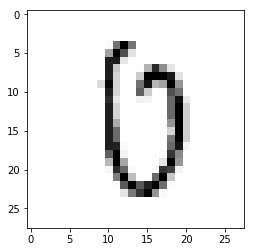

In [6]:
# Visualizing one of the samples
ax = plt.axes()
ax.imshow(data[0].reshape(28,28),cmap="Greys")

# 1.2 Code

In [7]:
# Stop showing warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [8]:
# define a function for selecting best k
def KNN_select(X, Y, possible_ks=[3, 5, 10, 20]):
    acc_list = []
    for k in possible_ks:
        print("training for k = %d"%k)
        clf = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(clf, X, Y, scoring='f1_macro', cv=5)
        acc_list.append(np.mean(scores))
        print("for k = %d scores are :"%k,scores)
        print("=========================================")
    Best_k = possible_ks[np.argmax(acc_list)]
    return Best_k

In [9]:
# define a function for selecting best number of trees for our decision tree alg.
def DT_select(X, Y, possible_depths=[10,20]):
    acc_list = []
    for d in possible_depths:
        print("training for depth = %d"%d)
        clf = DecisionTreeClassifier(random_state=0, max_depth=d)
        scores = cross_val_score(clf, X, Y, scoring='f1_macro', cv=5) 
        acc_list.append(np.mean(scores))
        print("for depth = %d scores are :"%d,scores)
        print("=========================================")
    Best_depth = possible_depths[np.argmax(acc_list)]
    return Best_depth

In [10]:
# define a function for selecting best number of trees for our random forest alg.
def RF_select(X, Y, possible_num_of_trees=[100, 300, 500, 1000]):
    acc_list = []
    for num in possible_num_of_trees:
        print("training for %d trees"%num)
        clf = RandomForestClassifier(n_estimators=num)
        scores = cross_val_score(clf, X, Y, scoring='f1_macro', cv=5) 
        acc_list.append(np.mean(scores))
        print("for %d trees scores are :"%num,scores)
        print("=========================================")
    Best_num_of_trees = possible_num_of_trees[np.argmax(acc_list)]
    return Best_num_of_trees

In [18]:
seed = 1000
np.random.seed(seed)

def KFold_split(X, Y, num_folds, seed):
    KFold_splitter = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    X_train_folds = []
    X_val_folds = []
    Y_train_folds = []
    Y_val_folds = []
    for (kth_fold_train_idxs, kth_fold_val_idxs) in KFold_splitter.split(X, Y):
        X_train_folds.append(X[kth_fold_train_idxs])
        X_val_folds.append(X[kth_fold_val_idxs])
        Y_train_folds.append(Y[kth_fold_train_idxs])
        Y_val_folds.append(Y[kth_fold_val_idxs])
    return X_train_folds, X_val_folds, Y_train_folds, Y_val_folds

### Construct a simple fully-connected MLP with SGD:
def build_MLP(input_shape, num_classes, activation_type, network_depth):
    MLP = Sequential()
    # Hidden layers (fully connected):
    MLP.add(Dense(input_shape=input_shape, units=30, activation=activation_type))
    if network_depth > 1:
        for i in range(1,network_depth):
            MLP.add(Dense(units=60, activation=activation_type))
    # Output layer (fully-connected):
    MLP.add(Dense(units=num_classes, 
                  activation='softmax'))
    MLP.compile(loss=categorical_crossentropy,
                optimizer='SGD',
                metrics=['accuracy'])
    return MLP

def MLP_select(X, Y, possible_depths=[1,2,3,4,5],
               possible_activation_functions=["sigmoid", "relu"],
               batch_sizes=[50,100,200,500],
               num_epochs=[50,100,200,500]):
    acc_list = [[[[0 for b in range(len(batch_sizes))]
                  for e in range(len(num_epochs))]
                 for a in range(len(possible_activation_functions))]
                for d in range(len(possible_depths))]
    input_shape = (X.shape[1], )
    num_classes = 10
    Y = to_categorical(Y, num_classes)
    num_folds = 5
    X_train_folds, X_val_folds, Y_train_folds, Y_val_folds = KFold_split(X, Y, num_folds, seed)
    
    depth_index = 0
    for depth in possible_depths:
        activation_function_index = 0
        for activation_function in possible_activation_functions:
            epoch_index = 0
            for epoch in num_epochs:
                batch_size_index = 0
                for batch_size in batch_sizes:
                    model = KerasClassifier(build_fn=build_MLP, input_shape=input_shape, num_classes=num_classes,
                         activation_type=activation_function, network_depth=depth, epochs=epoch, batch_size=batch_size, verbose=0)
                    
                    print("training for Number of Hidden Layers:{}, Activation Function:{}, Num of Epocs:{}, Batch Size:{}"
                         .format(depth, activation_function,epoch,batch_size))
                          
                    for X_train_fold, X_val_fold, Y_train_fold, Y_val_fold in zip(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds):
                        model.fit(X_train_fold, Y_train_fold)
                        prediction = model.predict(X_val_fold)
                        acc_list[depth_index][activation_function_index][epoch_index][batch_size_index] +=\
                            f1_score(np.argmax(Y_val_fold,axis=1), prediction, average='macro')/num_folds
                    print("for Depth:{}, Activation Function:{}, Num of Epocs:{}, Batch Size:{} mean score is :"
                         .format(depth, activation_function,epoch,batch_size),
                         acc_list[depth_index][activation_function_index][epoch_index][batch_size_index])
                    print("=========================================")
                    batch_size_index = batch_size_index + 1
                epoch_index = epoch_index + 1
            activation_function_index = activation_function_index + 1
        depth_index = depth_index + 1

    

    acc_list = np.array(acc_list)
    best_depth_i, best_activation_function_i, best_num_epoch_i, best_batch_size_i = \
        np.unravel_index(acc_list.argmax(), acc_list.shape)
    best_depth, best_activation_function, best_num_epoch, best_batch_size = \
        possible_depths[best_depth_i],\
        possible_activation_functions[best_activation_function_i],\
        num_epochs[best_num_epoch_i],\
        batch_sizes[best_batch_size_i]
    
    return best_depth, best_activation_function, best_num_epoch, best_batch_size

In [12]:
def final_model_select(X, Y):
#     print("################____KNN____#################")
#     #  Find the best model with respect to different values of K
#     Best_k = KNN_select(X, Y, possible_ks=[5, 10])
#     print("The best k is: ", Best_k)
    
    print("################____DT____#################")
    #  Find the best model with respect to different values of depth
    Best_depth = DT_select(X, Y, possible_depths=[8, 15])
    print("The best depth is: ", Best_depth)
    
    print("################____RF____#################")
    # Find the best model with respect to different number of trees
    Best_num_of_trees = RF_select(X, Y, possible_num_of_trees=[100, 500])
    print("The best num of trees is: ", Best_num_of_trees)
    
    print("################____MLP____#################")
    Best_num_of_hidden_layers, Best_activation_function, best_num_epoch, best_batch_size =\
                                                                    MLP_select(X, Y,
                                                                    possible_depths=[0,1,7],
                                                                    possible_activation_functions=["sigmoid", "relu"],
                                                                    batch_sizes=[15,30],
                                                                    num_epochs=[25,50])
    print("The best number of hidden layers is: ", Best_num_of_hidden_layers)
    print("The best activation function is: ", Best_activation_function)
    print("The best number of epocs is: ", best_num_epoch)
    print("The best batchsize is: ", best_batch_size)
    
    print("========================Selection Between DT, RF, and MLP==========================")
    acc_list = [0 for i in range(3)]
    
#     #KNN
#     clf = KNeighborsClassifier(n_neighbors=Best_k)
#     scores = cross_val_score(clf, X, Y, scoring='f1_macro', cv=5) 
#     acc_list[0] = np.mean(scores)
#     print("K Neighbors Classifier Classification Performance: ",acc_list[0])
#     print("=========================================")

    #DT
    clf = DecisionTreeClassifier(random_state=0, max_depth=Best_depth)
    scores = cross_val_score(clf, X, Y, scoring='f1_macro', cv=5) 
    acc_list[0] = np.mean(scores)
    print("Decision Tree Classification Performance: ",acc_list[0])
    print("=========================================")
    
    # RF
    clf = RandomForestClassifier(n_estimators=Best_num_of_trees)
    scores = cross_val_score(clf, X, Y, scoring='f1_macro', cv=5)
    acc_list[1] = np.mean(scores)
    print("Random Forest Classifier Classification Performance: ",acc_list[1])
    print("=========================================")
    
    #MLP
    input_shape = (X.shape[1], )
    num_classes = 10
    Y = to_categorical(Y, num_classes)
    num_folds = 5
    clf = KerasClassifier(build_fn=build_MLP, input_shape=input_shape, num_classes=num_classes,
            activation_type=Best_activation_function, network_depth=Best_num_of_hidden_layers,
                          epochs=best_num_epoch, batch_size=best_batch_size, verbose=0)
    X_train_folds, X_val_folds, Y_train_folds, Y_val_folds = KFold_split(X, Y, num_folds, seed)
    for X_train_fold, X_val_fold, Y_train_fold, Y_val_fold in zip(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds):
        clf.fit(X_train_fold, Y_train_fold)
        prediction = clf.predict(X_val_fold)
        acc_list [2] += f1_score(np.argmax(Y_val_fold,axis=1), prediction, average='macro')/num_folds
    print("MLP Classifier Classification Performance: ",acc_list[2])
    print("=========================================")
    
    model_index = np.argmax(acc_list)
    
    if model_index==0:
#         print("The best model is learnt by K Neighbors Classifier!")
#         model = KNeighborsClassifier(n_neighbors=Best_k)
        print("The best model is learnt by Decision Tree Classifier!")
        model = DecisionTreeClassifier(random_state=0, max_depth=Best_depth)
    elif model_index==1:
        print("The best model is learnt by Random Forest Classifier!")
        model = RandomForestClassifier(n_estimators=Best_num_of_trees)
    else:
        print("The best model is learnt by MLP Classifier!")
        model = KerasClassifier(build_fn=build_MLP, input_shape=input_shape, num_classes=num_classes,
                    activation_type=Best_activation_function, network_depth=Best_num_of_hidden_layers,
                    epochs=best_num_epoch, batch_size=best_batch_size, verbose=0)
        
    return model_index, model

In [13]:
# A preprocessing of data can be needed as the dimentionality of data and number of samples are large
# A model selection for dimentionality reduction
def preprocess_data(X, Y):
    
    def dim_red_ae(data,n_dims_encoded=20):
        input_layer = layers.Input(shape=(data.shape[1], ))
        encoding_layer = layers.Dense(n_dims_encoded,activation='tanh')(input_layer)
        decoding_layer = layers.Dense(data.shape[1],activation='tanh') (encoding_layer)
        autoencoder = models.Model(input_layer, decoding_layer)
        autoencoder.compile('adam', loss='mse')
        autoencoder.fit(x = data, y = data, epochs=5)
        encoder = models.Model(input_layer, encoding_layer)
        return encoder,autoencoder
    
    acc_list = []
    possible_dims = [300,400,500]
    for dims in possible_dims:
        print("training for %d dimensions"%dims)
        encoder,_ = dim_red_ae(X,dims)
        encodings = encoder.predict(X)
        clf = RandomForestClassifier().fit(encodings,Y)
        scores = cross_val_score(clf, encodings, Y, cv=5)
        acc_list.append(np.mean(scores))
        print("for %d dims scores are :"%dims,scores)
        print("=========================================")
    best_dim = possible_dims[np.argmax(acc_list)]
    
    encoder,_ = dim_red_ae(X,best_dim)
    processed_data = encoder.predict(X)
    return processed_data

In [14]:
# # preprocess the data
# processed_data = preprocess_data(data, labels)
# Devide data to train and test
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = 0.3, random_state = 0)

In [15]:
'''
The best model will be selected among {DT, Decision Tree, and MLP}
However, beforehand:
(-For KNN the best model with respect to different values of K will be selected)
-For DT the best model with respect to different values of max depth will be selected
-For DT the best model with respect to different number of trees will be selected
-For MLP the best model with respect to "different number of hidden layes", 
"types of activation functions" , "number of epocs", and "batchsize" will be selected

'''
# Model Selection
model_index, model = final_model_select(X_train, Y_train)

################____DT____#################
training for depth = 8
for depth = 8 scores are : [0.80025981 0.80975031 0.79846313 0.80527481 0.80632002]
training for depth = 15
for depth = 15 scores are : [0.86058851 0.86452152 0.85933953 0.86518803 0.85727826]
The depth is:  15
################____RF____#################
training for 100 trees
for 100 trees scores are : [0.96571259 0.9635131  0.96440118 0.96285871 0.96681695]
training for 500 trees
for 500 trees scores are : [0.9668079  0.96708214 0.96672265 0.96455033 0.9696471 ]
The best num of trees is:  500
################____MLP____#################
training for Depth:0, Activation Function:sigmoid, Num of Epocs:25, Batch Size:15
for Depth:0, Activation Function:sigmoid, Num of Epocs:25, Batch Size:15 mean score is : 0.8724698280246124
training for Depth:0, Activation Function:sigmoid, Num of Epocs:25, Batch Size:30
for Depth:0, Activation Function:sigmoid, Num of Epocs:25, Batch Size:30 mean score is : 0.8890157139693442
training

In [16]:
# Model Evaluation

if model_index==0: #DT
    model.fit(X_train, Y_train)
    pred_Y = model.predict(X_test)
    Classification_Performance = f1_score(Y_test, pred_Y, average='macro')
elif model_index==1: #RF
    model.fit(X_train, Y_train)
    pred_Y = model.predict(X_test)
    Classification_Performance = f1_score(Y_test, pred_Y, average='macro')
else: #MLP
    num_classes = 10
    Y_train_cat = to_categorical(Y_train, num_classes)
    Y_test_cat = to_categorical(Y_test, num_classes)
    model.fit(X_train, Y_train_cat)
    pred_Y = model.predict(Y_test_cat)
    Classification_Performance = f1_score(Y_test, pred_Y, average='macro')
    
print("The Classification Performance for test set is: ", Classification_Performance)

The Classification Performance for test set is:  0.9708338999042571


In [17]:
# Train the selected model on the whole data (there will be no evaluation)
if model_index==0: #DT
    model.fit(data, labels)
elif model_index==1: #RF
    model.fit(data, labels)
else: #MLP
    num_classes = 10
    labels_cat = to_categorical(labels, num_classes)
    model.fit(data, labels_cat)

print("=========================================")
print("THE FINAL MODEL IS GENERATED!")
print("=========================================")

THE FINAL MODEL IS GENERATED!
